# The frequency of severe EHF (> 1) events is overestimated in the CAFEf6 forecasts when the EHF is calculated from bias corrected daily temperature. This notebook tries to understand why.

Note that using mutliplicative bias correction of T, rather than additive, makes negligible difference to the following

In [1]:
import xarray as xr

from src import utils

import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

## Cluster

In [3]:
from distributed import Client
from dask_jobqueue import PBSCluster

walltime = "02:00:00"
cores = 48
memory = "192GB"
cluster = PBSCluster(
    processes=1,
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-q express",
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83+gdata/oi10+gdata/ua8",
    ],
    local_directory="$PBS_JOBFS",
    header_skip=["select"],
)

cluster.scale(jobs=1)
client = Client(cluster)
print(f"Dask daskboard link: {client.dashboard_link}")

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Dask daskboard link: http://10.6.54.36:8787/status


## First, let's check our bias correction

In [4]:
f6 = xr.open_zarr("../../data/processed/CAFEf6.daily.abc_1991-2020.t_ref_Aus.zarr")
agcd = xr.open_zarr("../../data/processed/AGCD.daily.full.t_ref_Aus.zarr")

In [5]:
period = ["1991-01-01", "2020-12-31"]

agcd_clim = (
    utils.keep_period(agcd, period).groupby("time.dayofyear").mean("time").compute()
)
f6_clim = utils.keep_period(f6, period).mean(["init", "member"]).compute()

In [6]:
lead = 500

f6_clim_at_lead = f6_clim.isel(lead=lead)
agcd_clim_at_lead = agcd_clim.sel(dayofyear=((lead + 305) % 365))

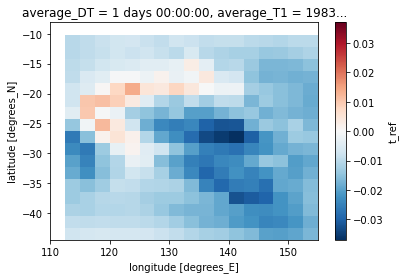

In [7]:
(f6_clim_at_lead - agcd_clim_at_lead)["t_ref"].plot()

## How do individual timeseries look?

In [8]:
init = 20
sel = dict(lat=10, lon=10)

f6_ts = f6["t_ref"].isel({**sel, "init": init}).swap_dims({"lead": "time"}).compute()
agcd_ts = agcd["t_ref"].isel(sel).sel(time=f6_ts.time).compute()

Text(0.5, 1.0, 'Additive bias correction')

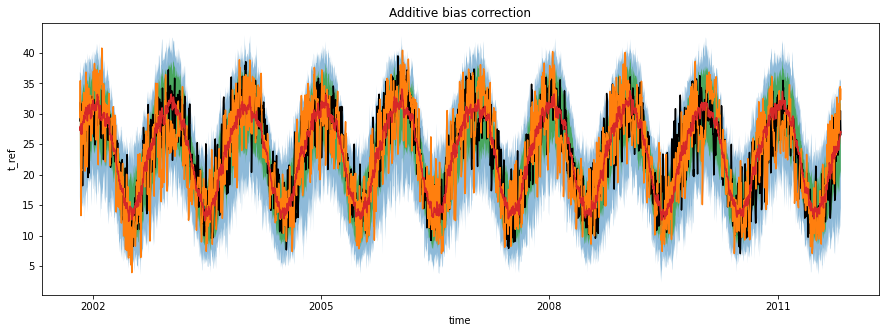

In [9]:
fig = plt.figure(figsize=(15, 5))

plt.fill_between(
    f6_ts.time.values,
    f6_ts.min("member"),
    f6_ts.max("member"),
    color="C0",
    alpha=0.5,
    edgecolor=None,
)
plt.fill_between(
    f6_ts.time.values,
    f6_ts.quantile(0.1, "member"),
    f6_ts.quantile(0.9, "member"),
    color="C2",
    alpha=0.7,
    edgecolor=None,
)
agcd_ts.plot(color="k")
f6_ts.isel(member=0).plot(color="C1")
f6_ts.mean("member").plot(color="C3")

plt.title("Additive bias correction")

## What about for EHF?

In [10]:
f6["ehf"] = utils.calculate_EHF(
    f6,
    T_p95_file="data/processed/AGCD.daily.p95_1971-2000.t_ref_Aus.zarr",
    rolling_dim="lead",
)["ehf"]
agcd["ehf"] = xr.open_zarr("../../data/processed/AGCD.daily.full.ehf_Aus.zarr")["ehf"]

In [11]:
init = 20
sel = dict(lat=10, lon=10)

f6_ts = f6["ehf"].isel({**sel, "init": init}).swap_dims({"lead": "time"}).compute()
agcd_ts = agcd["ehf"].isel(sel).sel(time=f6_ts.time).compute()

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


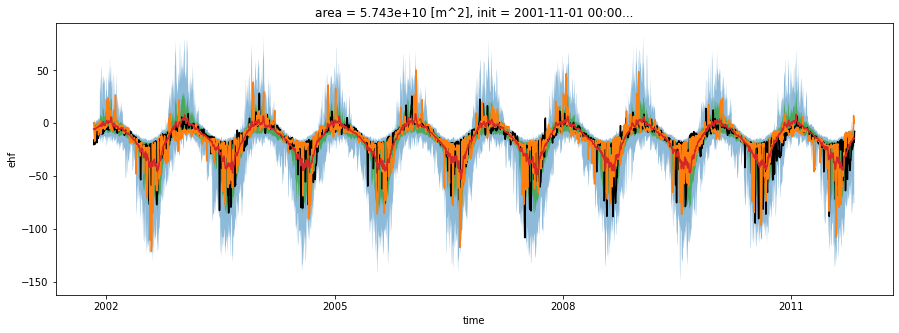

In [12]:
fig = plt.figure(figsize=(15, 5))

plt.fill_between(
    f6_ts.time.values,
    f6_ts.min("member"),
    f6_ts.max("member"),
    color="C0",
    alpha=0.5,
    edgecolor=None,
)
plt.fill_between(
    f6_ts.time.values,
    f6_ts.quantile(0.1, "member"),
    f6_ts.quantile(0.9, "member"),
    color="C2",
    alpha=0.7,
    edgecolor=None,
)
agcd_ts.plot(color="k")
f6_ts.isel(member=0).plot(color="C1")
f6_ts.mean("member").plot(color="C3")

## And EHF severity?

In [13]:
f6["ehf_severity"] = xr.open_zarr(
    "../../data/processed/CAFEf6.daily.full.ehf_severity_Aus.zarr"
)["ehf_severity"]
agcd["ehf_severity"] = xr.open_zarr(
    "../../data/processed/AGCD.daily.full.ehf_severity_Aus.zarr"
)["ehf_severity"]

In [14]:
init = 20
sel = dict(lat=10, lon=10)

f6_ts = (
    f6["ehf_severity"].isel({**sel, "init": init}).swap_dims({"lead": "time"}).compute()
)
agcd_ts = agcd["ehf_severity"].isel(sel).sel(time=f6_ts.time).compute()

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


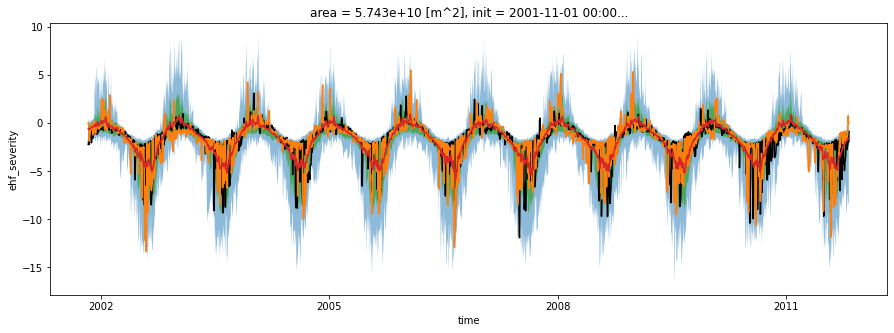

In [15]:
fig = plt.figure(figsize=(15, 5))

plt.fill_between(
    f6_ts.time.values,
    f6_ts.min("member"),
    f6_ts.max("member"),
    color="C0",
    alpha=0.5,
    edgecolor=None,
)
plt.fill_between(
    f6_ts.time.values,
    f6_ts.quantile(0.1, "member"),
    f6_ts.quantile(0.9, "member"),
    color="C2",
    alpha=0.7,
    edgecolor=None,
)
agcd_ts.plot(color="k")
f6_ts.isel(member=0).plot(color="C1")
f6_ts.mean("member").plot(color="C3")

## This might look somewhat reasonable, but the actually number of heatwave days predicted for each member (e.g. orange line) is substantially higer (~ 2x) what is observed:

In [16]:
(agcd_ts > 0).sum("time").values

array(195)

In [17]:
(f6_ts > 0).sum("time").values

array([353, 358, 399, 446, 544, 482, 403, 451, 451, 414, 477, 374, 393,
       368, 365, 319, 405, 384, 389, 329, 407, 460, 196, 455, 418, 364,
       349, 319, 403, 382, 389, 396, 423, 289, 463, 349, 431, 446, 377,
       429, 413, 406, 422, 404, 269, 401, 399, 477, 461, 355, 315, 404,
       401, 389, 346, 427, 492, 502, 408, 342, 418, 433, 464, 366, 340,
       407, 379, 404, 373, 409, 437, 360, 296, 370, 376, 411, 396, 423,
       436, 443, 398, 383, 464, 333, 389, 479, 446, 383, 413,   0, 430,
       405, 249, 549, 434, 244])

### Thus the proportion per year is too high

In [18]:
f6_p = xr.open_zarr(
    "../../data/processed/CAFEf6.annual.days_over_0.ehf_severity_Aus.zarr"
)
agcd_p = xr.open_zarr(
    "../../data/processed/AGCD.annual.days_over_0.ehf_severity_Aus.zarr"
)

In [19]:
lead = 1
sel = dict(lat=10, lon=10)

f6_ts = utils.keep_period(
    f6_p["ehf_severity"]
    .isel({**sel, "lead": lead})
    .swap_dims({"init": "time"})
    .compute(),
    period,
)
agcd_ts = agcd_p["ehf_severity"].isel(sel).sel(time=f6_ts.time).compute()

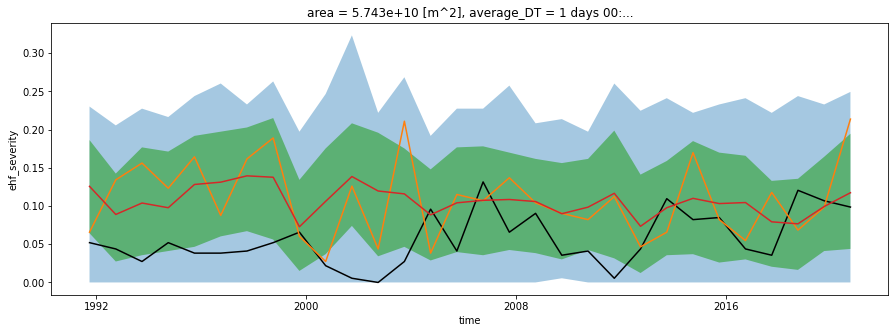

In [20]:
fig = plt.figure(figsize=(15, 5))

plt.fill_between(
    f6_ts.time.values,
    f6_ts.min("member"),
    f6_ts.max("member"),
    color="C0",
    alpha=0.4,
    edgecolor=None,
)
plt.fill_between(
    f6_ts.time.values,
    f6_ts.quantile(0.1, "member"),
    f6_ts.quantile(0.9, "member"),
    color="C2",
    alpha=0.6,
    edgecolor=None,
)
agcd_ts.plot(color="k")
f6_ts.isel(member=10).plot(color="C1")
f6_ts.mean("member").plot(color="C3")

In [21]:
cluster.close()
client.close()